In [1]:
import numpy as np
import pandas as pd 
import torch
import torchvision
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd.variable import Variable


In [20]:
def mnist_data():
    compose = transforms.Compose(
        [transforms.ToTensor(),
        
         transforms.Normalize([0.5], [0.5])
        ])
    out_dir = './dataset'
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)
# Load data
data = mnist_data()
# Create loader with data, so that we can iterate over it
data_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)
# Num batches
num_batches = len(data_loader)

In [22]:
train=datasets.MNIST('',train=True,download=True,transform=transforms.Compose([transforms.ToTensor()]))
test=datasets.MNIST('',train=True,download=False,transform=transforms.Compose([transforms.ToTensor()]))
n_batch=100
trainset=torch.utils.data.DataLoader(train,batch_size=n_batch,shuffle=True)
testset=torch.utils.data.DataLoader(test,batch_size=n_batch,shuffle=True)


In [33]:
class G(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1=nn.Sequential(
        nn.Linear(128,256),
        nn.LeakyReLU(0.2))
        self.hidden2=nn.Sequential(
        nn.Linear(256,512),
        nn.LeakyReLU(0.2)
        )
        self.hidden3=nn.Sequential(
        nn.Linear(512,784),
        nn.Tanh())
        
        
    def forward(self,x):
        x=self.hidden1(x)
        x=self.hidden2(x)
        x=self.hidden3(x)
       
        return x
    

In [34]:
class D(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(D, self).__init__()
        n_features = 784
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 512),
            nn.LeakyReLU(0.2)
          
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.out(x)
        return x

In [35]:
# draw random noise from normal (0,1) to fit into generator
def noise(size):
    n=Variable(torch.randn(size,128))
    return n
    

In [36]:
def train_disc(optimizer,real_data,fake_data):
    N=real_data.size(0)
    optimizer.zero_grad()
    
    # train with real_data
    out_real=disc(real_data)
    loss_real=loss(out_real,ones_target(N))
    loss_real.backward()
    
    #train with fake data
    out_fake=disc(fake_data)
    loss_fake=loss(out_fake,zeros_target(N))
    loss_fake.backward()
    
    #update weight with gradient
    optimizer.step()
    
    return loss_real+loss_fake,out_real,out_fake
    
    

In [37]:
def train_gene(optimizer,fake_data):
    N=fake_data.size(0)
    optimizer.zero_grad()
    out=disc(fake_data)
    loss_g=loss(out,ones_target(N))
    loss_g.backward()
    optimizer.step()
    
    return loss_g

In [38]:
def zeros_target(size):
    '''tensor containing zeros with shape = size'''
    target=Variable(torch.zeros(size,1))
    return target

def ones_target(size):
    '''tensor containing zeros with shape = size'''
    target=Variable(torch.ones(size,1))
    return target

In [39]:
##visialize test
num_test_samples = 16
test_noise = noise(num_test_samples)

In [41]:
def show_images(images):
    images=torchvision.utils.make_grid(images)
    show_image(images[0])
def show_image(img):
    plt.imshow(img,cmap='Greys_r')
    plt.show()
    

In [42]:
def images_to_vectors(images):
    return images.view(images.size(0),784)
def vectors_to_images(vectors):
    return vectors.view(vectors.size(0),1,28,28)

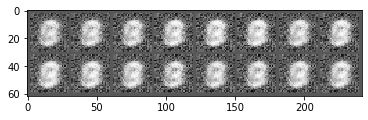

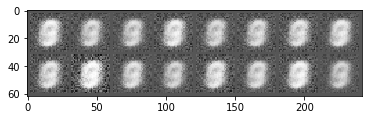

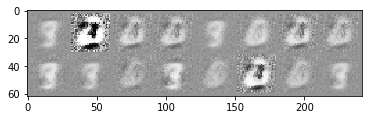

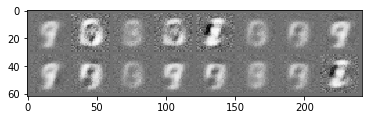

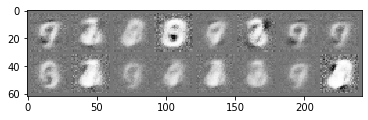

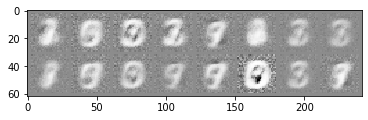

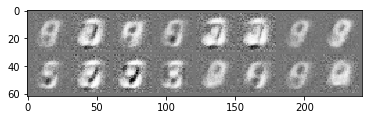

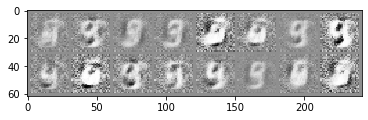

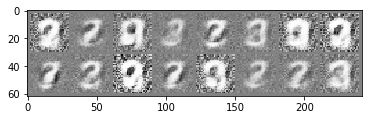

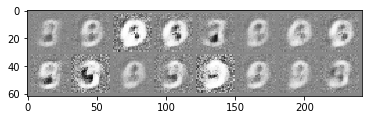

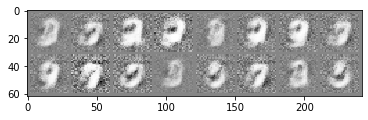

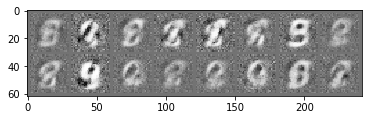

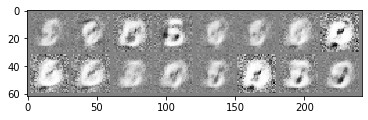

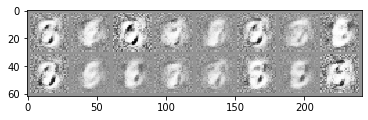

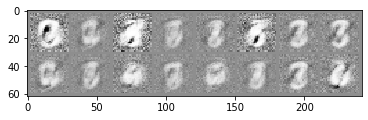

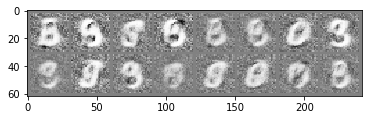

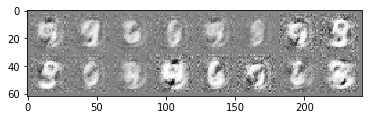

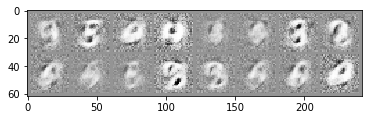

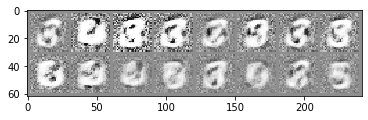

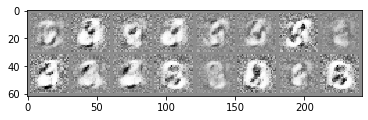

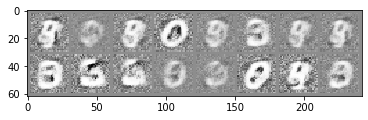

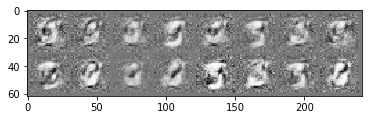

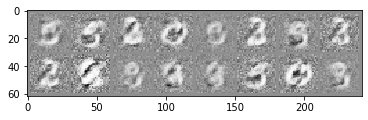

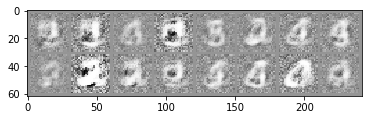

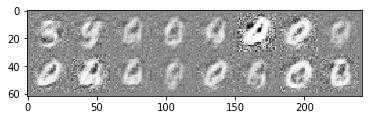

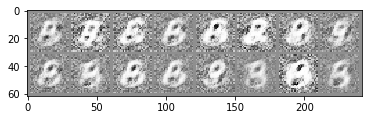

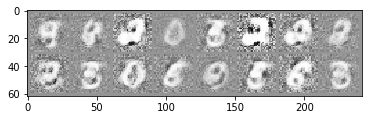

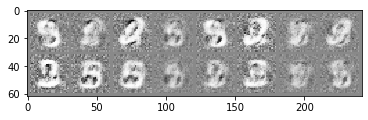

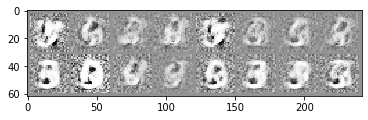

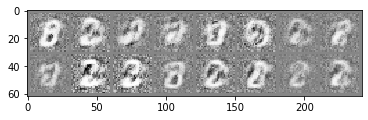

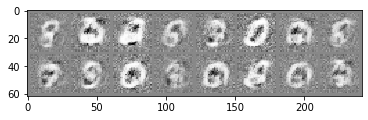

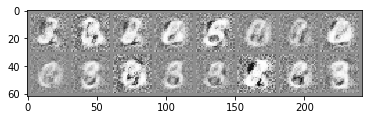

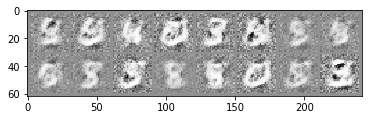

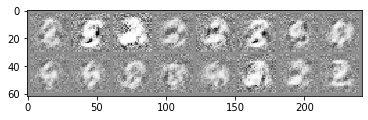

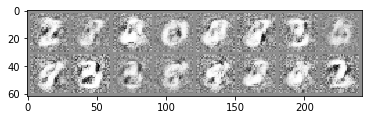

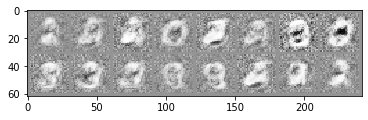

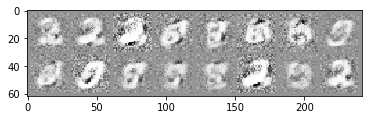

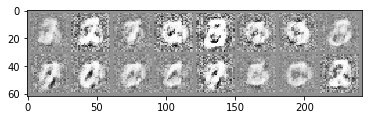

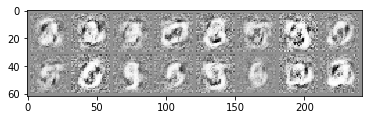

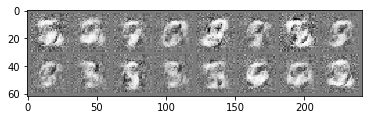

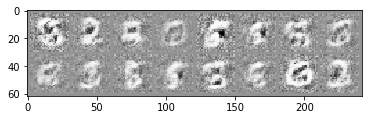

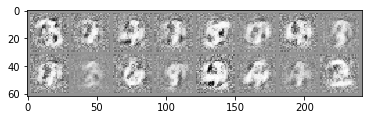

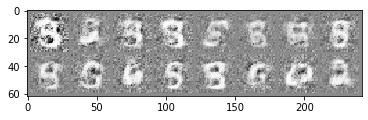

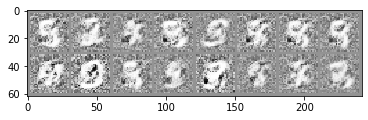

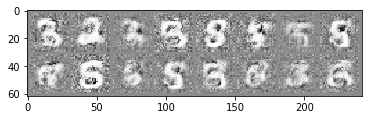

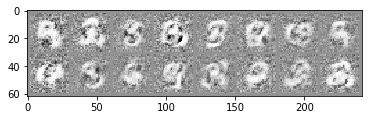

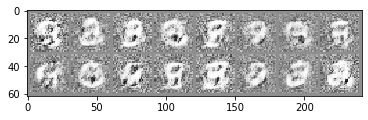

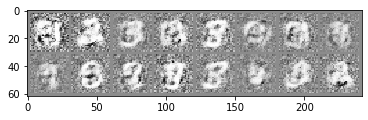

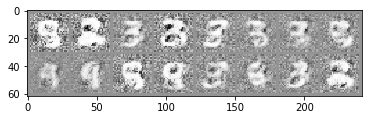

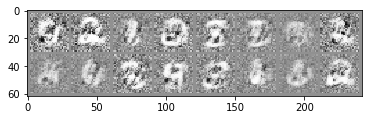

In [43]:
#Q what's logger
#Q what's real_data.size(0)
#Q (real_batch,_) why?

# optimization

#initial
gene=G()
disc=D()
loss=nn.BCELoss()
d_optimizer=optim.Adam(disc.parameters(),lr=0.0005)
g_optimizer=optim.Adam(gene.parameters(),lr=0.0005)
Epochs=50
d_losses=list()
g_losses=list()


for epoch in range(Epochs):
    g_loss=0
    d_loss=0
    for n, (real_batch,_) in enumerate(trainset):
        N=real_batch.size(0)
        
        #1 train discriminator
        real_data=Variable(images_to_vectors(real_batch))
        
        #generate fake data and detach
        
        fake_data=gene(noise(N)).detach()
       
        d_error,d_pred_real,d_pred_fake=train_disc(d_optimizer,real_data,fake_data)
        
        
        #2. train generator
        fake_data=gene(noise(N))
   
        g_error=train_gene(g_optimizer,fake_data)
        
        g_loss+=g_error
        d_loss+=d_error
      
    g_losses.append(g_loss)
    d_losses.append(d_loss)
        
   
    t_data=gene(test_noise)
    t_data=t_data.data
    show_images(t_data.view(16,-1,28,28))
    
        
            
            
            
        
        
       
        
    
    

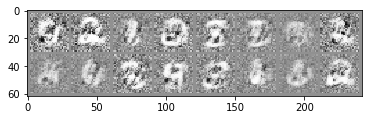

In [46]:

test_img=vectors_to_images(gene(test_noise))
test_img=test_img.data
show_images(test_img)

In [47]:

# save model
torch.save(gene.state_dict(),'hw5_GAN_dis.pth')
# save model
torch.save(disc.state_dict(),'hw5_GAN_gen.pth')

           

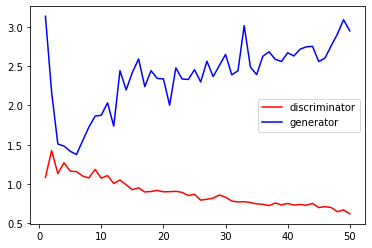

In [67]:
n_batches=len(trainset)
d1=list(map(lambda x:x/600,d_losses))
g1=t1=list(map(lambda x:x/600,g_losses))
plt.plot(range(1,51),d1,color='r',label='discriminator')
plt.plot(range(1,51),g1,color='blue',label='generator')
plt.legend()

